In [1]:
from functools import reduce
from collections import namedtuple
import matplotlib.pyplot as plt
from queue import PriorityQueue, SimpleQueue, LifoQueue

import numpy as np

In [2]:
PROBLEM_SIZE = 20        #number of elements in the set
NUM_SETS = 40       #number of sets
SETS = tuple(
    np.array([np.random.rand() < 0.2 for _ in range(PROBLEM_SIZE)])
    for _ in range(NUM_SETS)
)   # creates tuple of num_sets np.array where each contains problem_size elements with 30% prob of being true
State = namedtuple('State', ['taken', 'not_taken']) 
# each state is defined by the taken sets and the not-taken sets, can be accessed similarly to a dict
# note that it saves the index of the subset taken and not the actual subset

In [3]:
# checks if I actually took all the sets with an or executed between all taken sets for that particular state
def goal_check(state):
    return np.all(reduce(
        np.logical_or,
        [SETS[i] for i in state.taken],
        np.array([False for _ in range(PROBLEM_SIZE)]),
    ))
# starts with an array of False (the inial)
# [SETS[i] for i in state.taken] creates a list of lists (the taken subsets)
# applies `or` to each of element of the first subset and to the initial
# then it applies the or to each elements of the second subset and the new initial
# goes on like this, if everything inside initial is now True
# then np.all returns True and we have a valid solution

#checks how many elements are missing from the state to the final solution (all True)
def distance(state):
    return PROBLEM_SIZE - sum(
        reduce(
            np.logical_or,
            [SETS[i] for i in state.taken],     # state saves only the number of the taken subset
            np.array([False for _ in range(PROBLEM_SIZE)]),
        ))
# creates a list of lists (subsets) that are in state.taken
# the reduce works in the same way of the previous method 
# so it returns an array of true and false 
# sum then treats Trues as 1s, so it counts the elements actually taken
# and the subtraction then returns how many elements are missing

# the heuristics represents a lower bound for the problem
def h(state):
    already_covered = reduce(
        np.logical_or,
        [SETS[i] for i in state.taken],
        np.array([False for _ in range(PROBLEM_SIZE)]),
    )   # returns which elements are already covered in the current state using 
        # True or False in the final array returned by the reduce

    if np.all(already_covered):     # no additional elements needed, program dies otherwise
        return 0
    
    not_covered = PROBLEM_SIZE - sum(already_covered)   # check which elements are not covered yet, just a number
    
    candidates = sorted((sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS), reverse=True)
    # computes how many uncovered elements each set can cover
    # the logical not pretty much returns the opposite of what is given (True --> False, 3 --> False, 0 ---> True)
    # the logical and computes the and between the current set and the ("opposite") already covered
    # if an element was covered --> False, if the element is in the set --> True, so the and gives False (lower importance)
    # if an element was not covered --> True, if the element is in the set --> Tue, so we care about this set more
    # then you have the element covered --> False, element not in set --> False, so all False
    # element not covered --> True, element not in set --> False, again False
    # we then sort in descending order based on the sum of how many True where found (the more we cover the more importance)
    
    taken_sets = 1
    while sum(candidates[:taken_sets]) < not_covered:
    # the loop continues as long as the total number of uncovered elements that can be covered by the "taken" largest subsets 
    # is less than the number of elements that are still missing
    # first iteration takes candidates[0], sums the True values and checks if it is enough to cover all the not_covered elements
    # if it is True (meaning it is not enough to cover all universe), then increment taken to consider one more subset
    # the loop will end when the sum of the lists >= not_covered, so the subsets considered are enough to cover all elements
    # this means that "taken" subsets are at least necessary to cover the universe
        taken_sets += 1
    return taken_sets   # returns the number of sets that are at least necessary to cover the universe

def f(state):
    # the cost function is defined as g(n) being how many sets we have taken up to now
    # and h(n) being the estimated distance from now to the goal state
    return len(state.taken) + h(state)


In [4]:
# assert checks if an expression returns True followed by a message in case of False
# the expression in this case is the goal_check function and the state that it
# takes as input is where all the sets are taken, verifying if the currents
# subsets permit the program to be solvable, otherwise the program will be stopped
assert goal_check(State(set(range(NUM_SETS)), set())), "Problem not solvable"

In [5]:
def visualize_sets(sets_idx):
    taken_subset = SETS[sets_idx]   # we always work on indexes so we have to take the actual set's elements
    
    plt.figure(figsize=(10, 2))
    plt.imshow(taken_subset.reshape((1, -1)), cmap="Accent_r")  # reverse the colormap to have green for the True
    # reshaped to have one row and PROBLEM_SIZE columns
    plt.title(f"Set {sets_idx}")
    plt.xticks(np.arange(PROBLEM_SIZE)) # from 0 to PROBLEM_SIZE
    plt.yticks([])  # otherwise it puts values from 0 to 1
    plt.grid(True, axis="x")
    plt.show()

Solved in 498 steps (5 tiles)
Taken subsets: {33, 3, 9, 21, 31}
Green = present, grey = not present


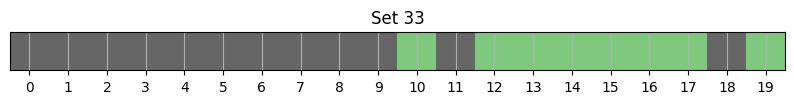

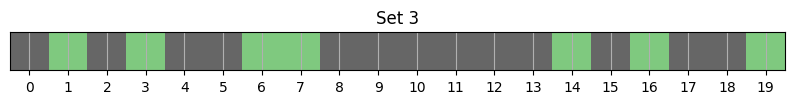

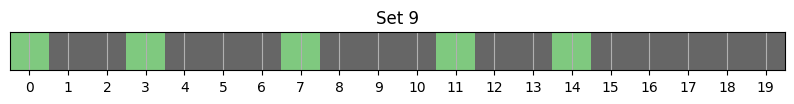

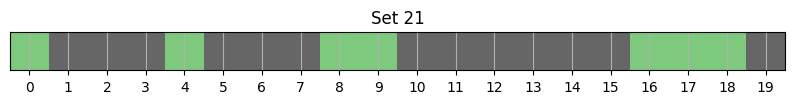

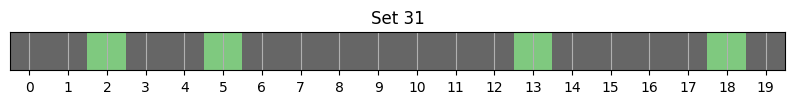

In [6]:
frontier = PriorityQueue()  # set of all states that have been reached but not explored yet
                            # note that lower numbers equal higher priority
                            # in this case states with lower cost will be analyzed first
                            # (priority = current cost = numb of sets, content = state)
state = State(set(), set(range(NUM_SETS)))  # initialize state and sets taken as empty, while not_taken all subsets
frontier.put((f(state), state))  # adds the initial state to the frontier, using the f function previously defned
# note that h(n) depends on how many are missing, so we start from PROBLEM_SIZE as first key

counter = 0
_, current_state = frontier.get()
while not goal_check(current_state):    # continue till goal_state is reached
    counter += 1
    for set in current_state.not_taken:  # iterate through the sets that have not been taken in this current state
        new_state = State(      # creates a new state by adding/removing the current set
            current_state.taken ^ {set},     # ^ opeartor: removes if present, add if not present
            current_state.not_taken ^ {set},
        )
        frontier.put((f(new_state), new_state)) # computes new cost function f(new_state) and adds it to the frontier
    _, current_state = frontier.get()
    
print(
    f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)"
)
print(f"Taken subsets: {current_state.taken}")
print("Green = present, grey = not present")
for sets_idx in current_state.taken:
    visualize_sets(sets_idx)